# Machine Learning Interpretability with Shapley values

Please see previous notebooks for more details.

Note: Shapley Values for neural nets appear to be based on probabilties of classification rather than log odds ratios, so may not be as theoretcially additive as log odds ratios.

## First set up Google Colab

First ensure you have selected GPU from 'runtime' / 'change runtime type'. This may require you then to restart the runtime.

Then run the code below to change TensorFlow version to 2.2.0. 

AFTER RUNNING THIS CELL PLEASE RESTART THE RUNTIME.

In [1]:
# Select 'GPU' from 'runtime' / 'change runtime type'

downgrade_tensorflow = True

import tensorflow
print(tensorflow.__version__)

if downgrade_tensorflow and tensorflow.__version__ != '2.2.0':
    !pip uninstall tensorflow
    !pip install tensorflow==2.2.0
    import tensorflow
    print(tensorflow.__version__)

2.2.0


## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# TensorFlow sequential model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Install shap if necessary (e.g. running in Google Colab)
try:
    import shap
except:
    !pip install shap
    import shap

## Classification: Titanic Survival

Here we load upa data set giving feature values for passengers on the Titanic, and whether they survived or not.

In [3]:
# Data will be loaded from web if not available locally (for Google Colab)
try:
    data = pd.read_csv('data/titanic.csv')
except:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

# Make all data 'float' type
data = data.astype(float)
# Drop passenger ID
data.drop(['PassengerId'], axis=1, inplace=True)

In [4]:
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,123.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Split X, and y, and split into training and test sets.

In [5]:
X = data.drop(['Survived'],axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Define a function to standardise the data using SciKit Learn's `MinMaxScaler`.

In [7]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [8]:
X_train_sc, X_test_sc = scale_data(X_train, X_test)

In [9]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()
    net.add(Dense(240, input_dim=number_features, activation='relu'))
    net.add(Dropout(0.2))
    net.add(Dense(50, input_dim=number_features, activation='relu'))
    net.add(Dense(1, activation='sigmoid'))    
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    
    net.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    
    return net

In [10]:
# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features)
    
### Train model
model.fit(X_train_sc,
         y_train,
         epochs=150,
         batch_size=32,
         verbose=0)

## Shapley values

In [11]:
explainer = shap.DeepExplainer(model, X_train_sc)

In [15]:
[z for z in dir(explainer) if z[0:2] != '__']

['_compute_main_effects',
 '_instantiated_load',
 'expected_value',
 'explain_row',
 'explainer',
 'load',
 'save',
 'shap_values',
 'supports_model_with_masker']

Get Shapley values. Note that the Shapley values can only be retrieved by themselves.

In [14]:
shap_values = explainer.shap_values(X_train_sc)

In [21]:
# Shap values for a single instance
shap_values[0][0]

array([-4.02940907e-02,  2.76044262e-03, -1.66652411e-03, -7.36528747e-03,
       -7.89959474e-03,  1.32390276e-02, -2.34877133e-04, -1.88785083e-03,
       -4.32989374e-03, -1.78793314e-02, -1.15038971e-01, -2.59227492e-02,
        5.84497323e-05,  6.37362276e-03, -2.90445069e-04, -1.56493285e-03,
       -3.97992224e-03, -1.89598035e-03, -2.60724620e-03, -1.37507786e-02,
        3.62562573e-04, -2.75624548e-04,  0.00000000e+00, -3.62687129e-03])

## Show global influence of features.

In [26]:
# Convert back to DataFrame to add feature names to chart
X_train_sc_df = pd.DataFrame(X_train_sc, columns=list(X_train))
X_test_sc_df = pd.DataFrame(X_test_sc, columns=list(X_train))

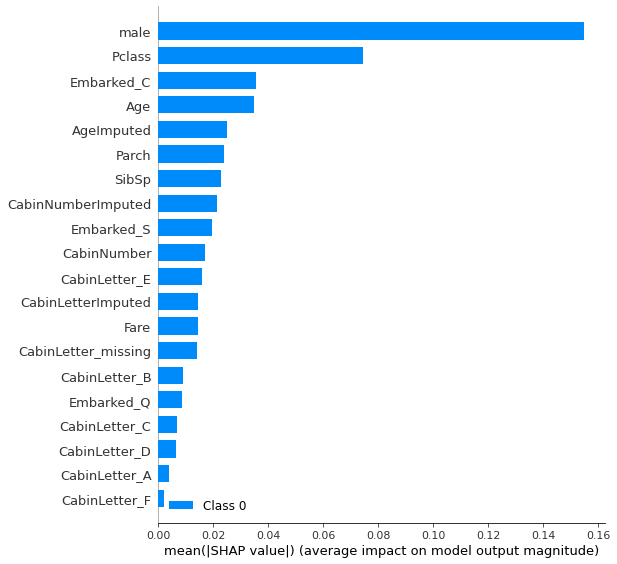

In [27]:
shap.summary_plot(shap_values, X_train_sc_df, plot_type='bar')

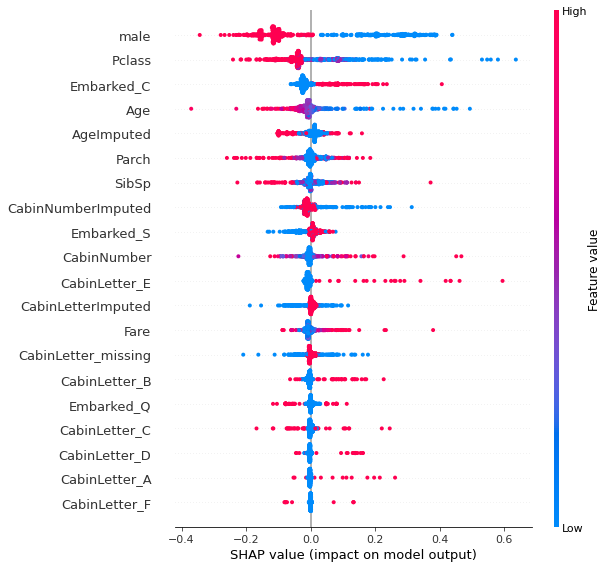

In [29]:
shap.summary_plot(shap_values[0], X_train_sc_df)

## Influence of features in individual examples in the test set

Here we will look at individial instance predictions, and how the different features contributed to prediction for that instance.

Let's examine the first test set instance:

In [30]:
X_test.iloc[0]

Pclass                  3.0000
Age                    15.0000
SibSp                   0.0000
Parch                   0.0000
Fare                    8.0292
AgeImputed              0.0000
EmbarkedImputed         0.0000
CabinLetterImputed      1.0000
CabinNumber             0.0000
CabinNumberImputed      1.0000
male                    0.0000
Embarked_C              0.0000
Embarked_Q              1.0000
Embarked_S              0.0000
Embarked_missing        0.0000
CabinLetter_A           0.0000
CabinLetter_B           0.0000
CabinLetter_C           0.0000
CabinLetter_D           0.0000
CabinLetter_E           0.0000
CabinLetter_F           0.0000
CabinLetter_G           0.0000
CabinLetter_T           0.0000
CabinLetter_missing     1.0000
Name: 22, dtype: float64

In [71]:
background = X_train_sc[np.random.choice(X_train_sc.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test_sc)

In [74]:
# Shap values for first instance
shap_values[0][0]

array([-0.02611195,  0.15969449,  0.04285029,  0.03188342,  0.00516332,
        0.02858821,  0.        ,  0.03252348, -0.02523596,  0.00123078,
        0.31763015, -0.01116503,  0.0804    , -0.07606219,  0.        ,
       -0.00339315,  0.00141853,  0.01691543,  0.00261723, -0.00235081,
        0.00240895,  0.        ,  0.        ,  0.02073488])

In [79]:
# Calculate Shap values
instance = 0
choosen_instance = X_test.iloc[instance]
shap_values_instance = shap_values[0][instance]
expected_value = np.repeat(explainer.expected_value, len(shap_values))
shap.initjs()
shap.force_plot(expected_value, shap_values_instance, choosen_instance)